# My COVID19 dashboard

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import plotly.express as px
import json
import re
from collections import Counter

pd.set_option("display.max_columns", None)

In [2]:
with open("rename_location.txt", "r") as f:
    rl = f.read()
    
rl = re.sub("\n", "", rl)
rl = json.loads(rl)

In [3]:
selected_columns = ['Virus name',
 'Accession ID',
 'Collection date',
 'Location',
 'Host',
 'Patient age',
 'Gender',
 'Clade',
 'Pango lineage',
 'Variant',
 'AA Substitutions']

start_date = "2021-01-01"
end_date = "2021-12-31"

dates_column = ["Collection date", "Submission date"]

malaysia_df = pd.read_csv("metadata_Malaysia.tsv", sep = "\t")

for d in dates_column:
    malaysia_df[d] = pd.to_datetime(malaysia_df[d])

mask = (malaysia_df['Collection date'] > start_date) & (malaysia_df['Collection date'] <= end_date)

malaysia_df = malaysia_df.loc[mask, selected_columns]
malaysia_df["Location"] = malaysia_df["Location"].map(rl)

## In 2021, what is the sequencing effort like between different states?

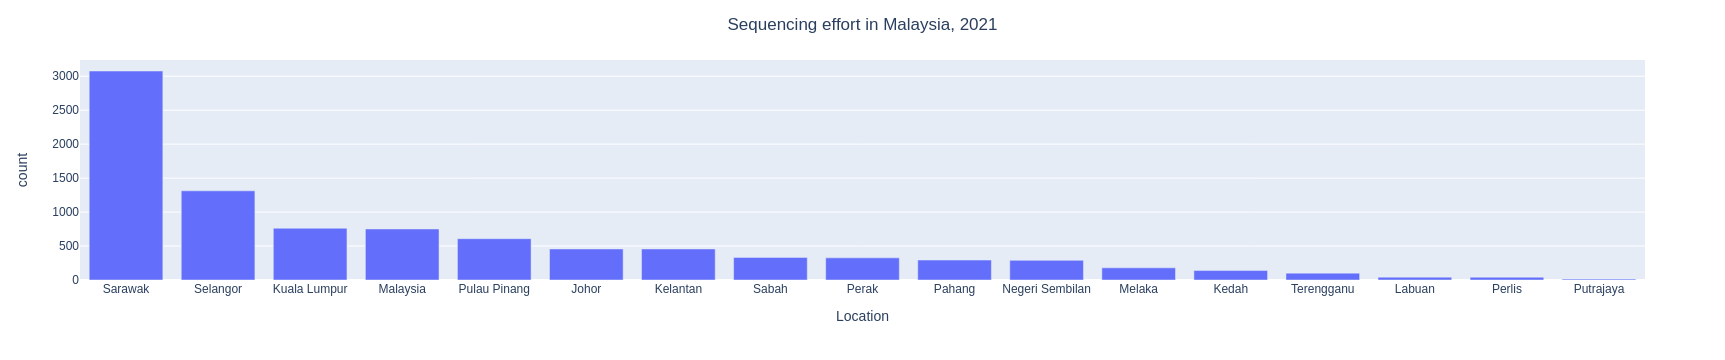

In [4]:
def seq_effort(df):
    vc = df["Location"].value_counts()
    vc = pd.DataFrame(vc)
    vc.index.name = "Location"
    vc.columns = ["count"]
    vc = vc.reset_index()
    vc["Location"] = vc["Location"].str.replace(".*/ ", "", regex = True)
    
    fig = px.bar(vc, x = 'Location', y = "count")
    
    return fig

fig = seq_effort(malaysia_df)
fig.update_layout(title_text=f"Sequencing effort in Malaysia, 2021", title_x=0.5)
fig

## In 2021, what is the distribution of COVID19 variants like in Malaysia?

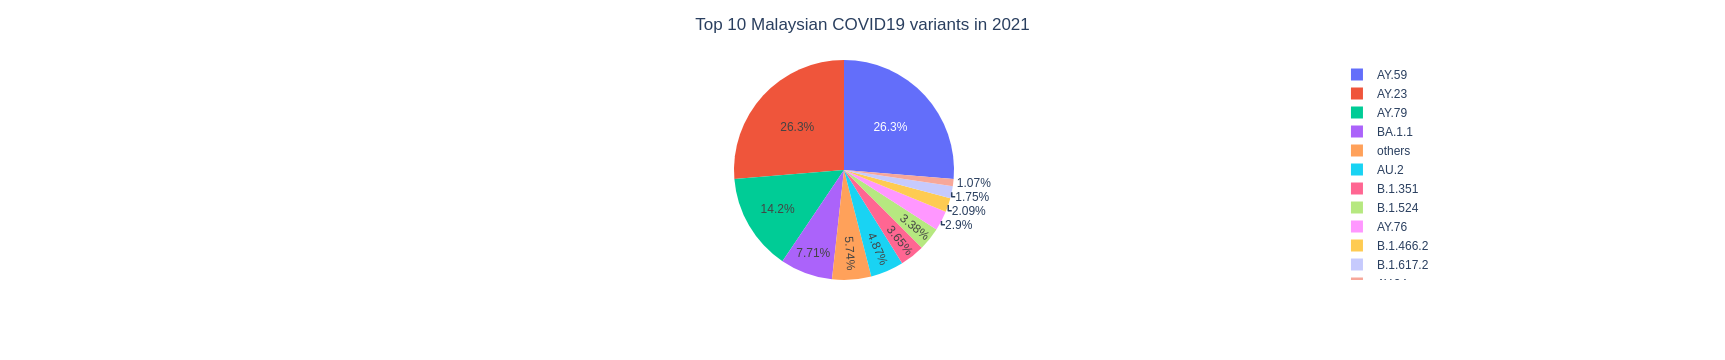

In [5]:
def gen_pie_COVID19(df):
    
    vc = df["Pango lineage"].value_counts()
    vc = pd.DataFrame(vc)
    vc.index.name = "lineage"
    vc.columns = ["count"]
    others = pd.DataFrame(vc.loc[vc.index[11:], :].sum()).T
    others.index = ["others"]
    vc.drop(vc.index[11:], inplace = True)
    vc = pd.concat([vc, others])
    
    fig = px.pie(vc, values = 'count', names = vc.index)
    
    return fig

fig = gen_pie_COVID19(malaysia_df)
fig.update_layout(title_text=f"Top 10 Malaysian COVID19 variants in 2021", title_x=0.5)
fig.show()



| Pango lineage   | Variant                                                                            |
|:----------------|:-----------------------------------------------------------------------------------|
| AY.59           | VOC Delta GK (B.1.617.2+AY.*) first detected in India                              |
| AY.79           | VOC Delta GK (B.1.617.2+AY.*) first detected in India                              |
| AY.76           | VOC Delta GK (B.1.617.2+AY.*) first detected in India                              |
| BA.1.1          | VOC Omicron GRA (B.1.1.529+BA.*) first detected in Botswana/Hong Kong/South Africa |
| AY.23           | VOC Delta GK (B.1.617.2+AY.*) first detected in India                              |
| AY.24           | VOC Delta GK (B.1.617.2+AY.*) first detected in India                              |
| B.1.617.2       | VOC Delta GK (B.1.617.2+AY.*) first detected in India                              |
| AY.79           | VOC Omicron GRA (B.1.1.529+BA.*) first detected in Botswana/Hong Kong/South Africa |
| B.1.351         | VOC Beta GH/501Y.V2 (B.1.351+B.1.351.2+B.1.351.3) first detected in South Africa   |
| AY.23           | VOC Omicron GRA (B.1.1.529+BA.*) first detected in Botswana/Hong Kong/South Africa |
| B.1.466.2       | VOC Delta GK (B.1.617.2+AY.*) first detected in India                              |

## What about Negeri Sembilan?

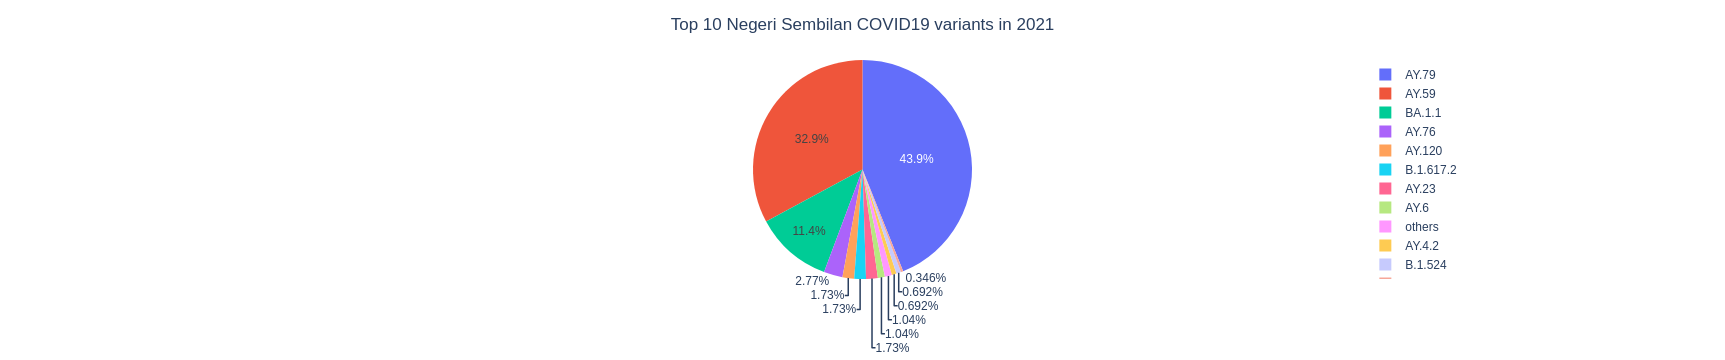

In [6]:
location = "Asia / Malaysia / Negeri Sembilan"

n9_df = malaysia_df.loc[malaysia_df["Location"] == location, :]
fig = gen_pie_COVID19(n9_df)
fig.update_layout(title_text=f"Top 10 Negeri Sembilan COVID19 variants in 2021", title_x=0.5)
fig.show()

** Be careful, both pie charts have a lot of red, but they represent different lineages. The Malaysian one represents AY.23, the Negeri Sembilan one represents AY.59.

## COVID19 variant distribution across months?

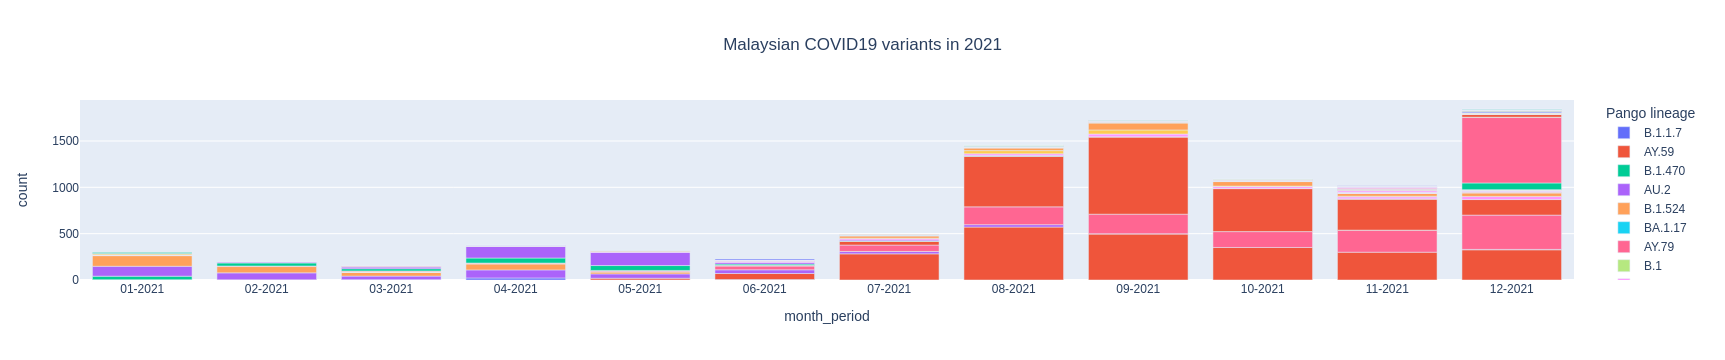

In [7]:
def get_dist_across_months(df):
    sdf = df.copy()
    sdf["month_period"] = sdf["Collection date"].dt.to_period("M").dt.strftime("%m-%Y")
    sdf = sdf.loc[:, ["Pango lineage", "month_period"]]
    
    
    # sdf["Pango lineage"] = pd.Categorical(sdf["Pango lineage"],
    #            sdf["Pango lineage"].value_counts().index.tolist(),
    #            ordered=True
    #           )
    
    sdf = pd.DataFrame(sdf.value_counts())
    sdf = sdf.reset_index()
    sdf.columns = ["Pango lineage", "month_period", "count"]
    sorted_months = [f"{str(i).zfill(2)}-2021" for i in range(1, 13)]
    
    sdf["month_period"] = pd.Categorical(sdf["month_period"],
               sorted_months,
               ordered=True
              )
    sdf.sort_values("month_period", inplace = True)
    # return sdf

    fig = px.bar(sdf, x="month_period", y="count", color="Pango lineage",
                 category_orders = {"month_period": sorted_months},
                 title="COVID19 across months")
    return fig

fig = get_dist_across_months(malaysia_df)
fig.update_layout(title_text=f"Malaysian COVID19 variants in 2021", title_x=0.5)
fig.show()

In [8]:
sorted_months = [f"{str(i).zfill(2)}-2021" for i in range(1, 13)]

** Careful, there is so many colours one can pick for so many lineages. These colours had to be cycled. So, hover over the bars to confirm which lineage it represents. Bars of the same colour might be different lineages.

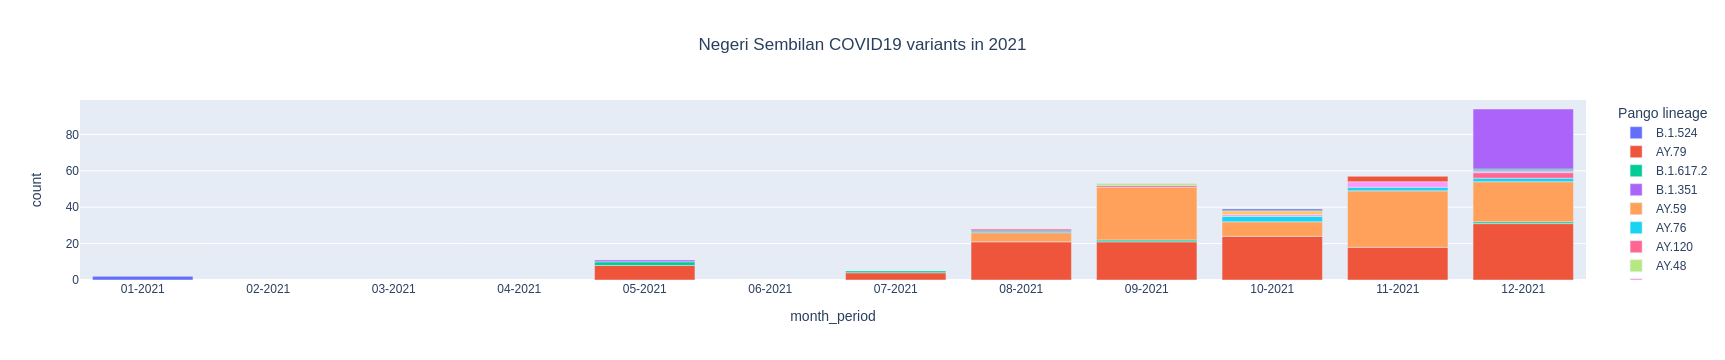

In [9]:
fig = get_dist_across_months(n9_df)
fig.update_layout(title_text=f"Negeri Sembilan COVID19 variants in 2021", title_x=0.5)
fig.show()

Wow, no sequencing from Negeri Sembilan from February to April. Even June is missing.
- AY.79 has been around since May. Who knows, maybe even earlier.
- AY.59 crept in later, maybe August.
- BA.1.1 (Omicron) appeared in December.
- Appearance of Omicron in Negeri Sembilan is consistent with the trend across the whole country.

In [10]:
def get_mutation(df, mut):
    arr = []
    for i in df["AA Substitutions"].tolist():
        try:
            l = i[1:-1].split(',')
            ans = mut in l
            arr.append(ans)
        except:
            ans = np.nan
            arr.append(ans)
    return arr

## Frequency of NSP3_P822L across months in Malaysia, 2021

In [11]:
mut = "NSP3_P822L"
sub_df = malaysia_df.copy()
sub_df["Month"] = sub_df["Collection date"].dt.to_period("M").dt.strftime("%m-%Y")

In [12]:
f = {}
mut = "NSP3_P822L"
sub_df = malaysia_df.copy()
sub_df["Month"] = sub_df["Collection date"].dt.to_period("M").dt.strftime("%m-%Y")
sub_df[mut] = get_mutation(sub_df, mut)

# Malaysia
f["Malaysia"] = pd.DataFrame(sub_df.loc[:, [mut, "Month"]]\
    .groupby("Month").sum()[mut]).rename(columns = {mut: "Malaysia"})

In [13]:
full_name_states = [i for i in sub_df["Location"].unique() if 'Asia / Malaysia / ' in i]

for state in full_name_states:
    nstate = re.sub(".*/ ", "", state)
    f[nstate] = pd.DataFrame(sub_df.loc[sub_df["Location"] == state, [mut, "Month"]]\
        .groupby("Month").sum()[mut]).rename(columns = {mut: nstate})

In [14]:
d = list(f.values())[0]
for i, k in enumerate(list(f.values())[1:]):
    d = pd.merge(
        d,
        list(f.values())[i + 1],
        left_index = True,
        right_index = True,
        how = "outer"
    )

d = d.reset_index().melt(id_vars = ["Month"], var_name = "Location", value_name = "Count")
# d.rename(columns = {"value": "Count", "variable": "Location"}, inplace = True)

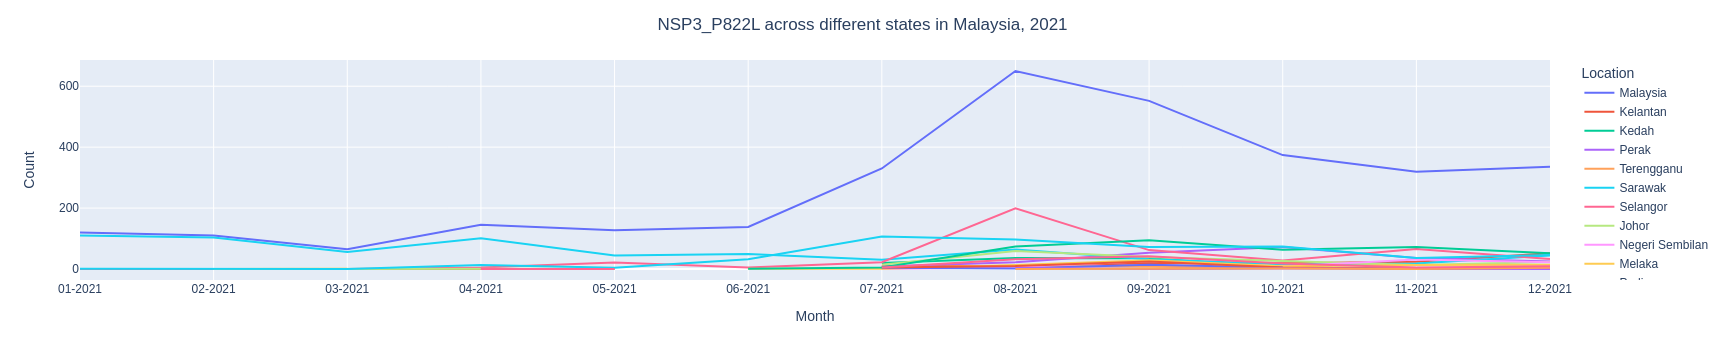

In [15]:
fig = px.line(d, x = "Month", y = "Count", color = "Location")
fig.update_layout(title_text=f"{mut} across different states in Malaysia, 2021 ", title_x=0.5)
fig.show()

## How often does the mutation occur between different lineages? At least in Malaysia..
We will look at the top 10 lineages in Malaysia first.

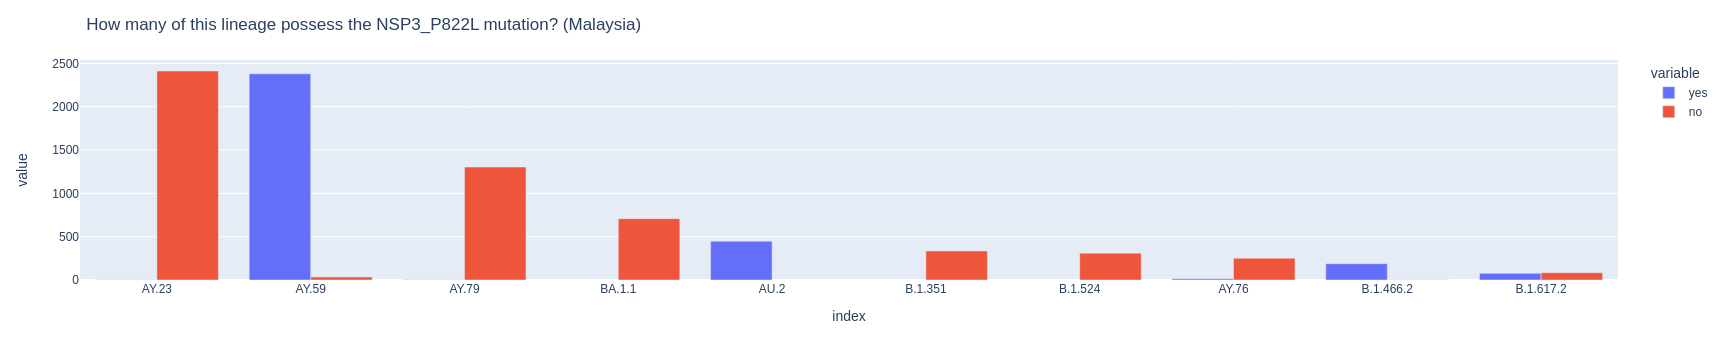

In [16]:
mut = "NSP3_P822L"

def plot_compare_mut(df, mut):
    sub_df = df.copy()
    sub_df[mut] = get_mutation(sub_df, mut)
    sub_df = sub_df.loc[:, ["Pango lineage", mut]]

    a = pd.DataFrame(
        sub_df.loc[sub_df[mut] == True, :]["Pango lineage"].value_counts()
    )

    b = pd.DataFrame(
        sub_df.loc[sub_df[mut] == False, :]["Pango lineage"].value_counts()
    )
    a.columns = ["yes"]
    b.columns = ["no"]

    c = a.merge(b, how = "outer", left_index = True, right_index = True)
    sorted_index = c.sum(axis = "columns").sort_values(ascending = False).index.tolist()[:10]
    c = c.loc[sorted_index, :]
    # c
    fig = px.bar(c, x = c.index, y = ["yes", "no"], barmode = "group")
    return fig

fig = plot_compare_mut(malaysia_df, mut)
fig.update_layout(title_text=f"How many of this lineage possess the {mut} mutation? (Malaysia)")
fig.show()

We can clearly see that a lineage either has it, or it doesn't. The prominent lineages that has the NSP3_P822L mutations are:
- AY.59
- AU.2
- B.1.466.2

Looking at the lineage distribution to look at the distribution of the three lineages.

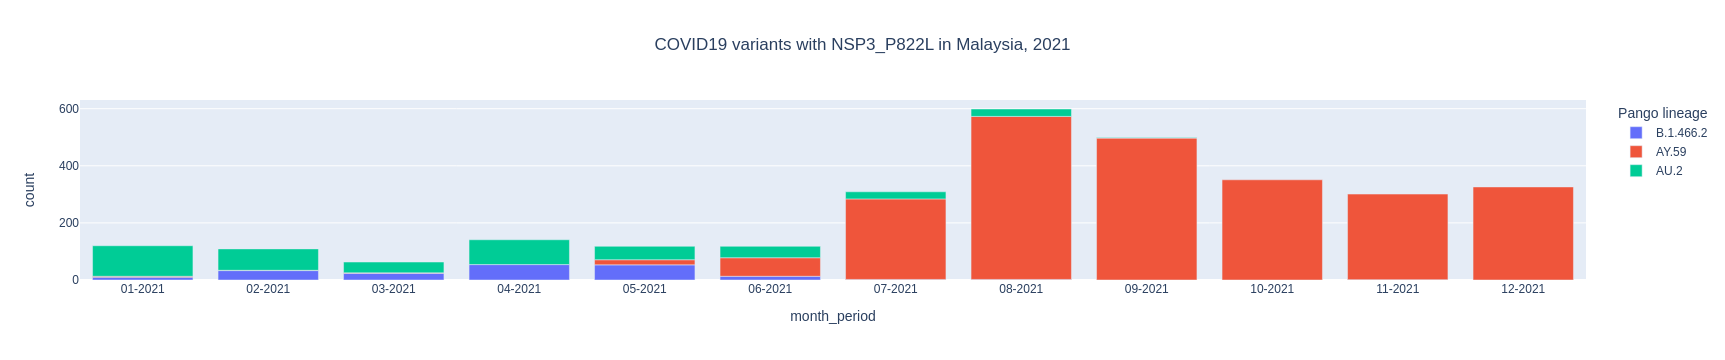

In [17]:
fig = get_dist_across_months(malaysia_df.loc[malaysia_df["Pango lineage"].isin(["AY.59", "AU.2", "B.1.466.2"]), :])
fig.update_layout(title_text=f"COVID19 variants with {mut} in Malaysia, 2021", title_x=0.5)
fig.show()

Some of my observation.
- AU.2 dwindled down, and died on Aug 2021
- B.1.4666.2 appeared and died swiftly
- AY.59 blew up!

What about Negeri Sembilan specifically?

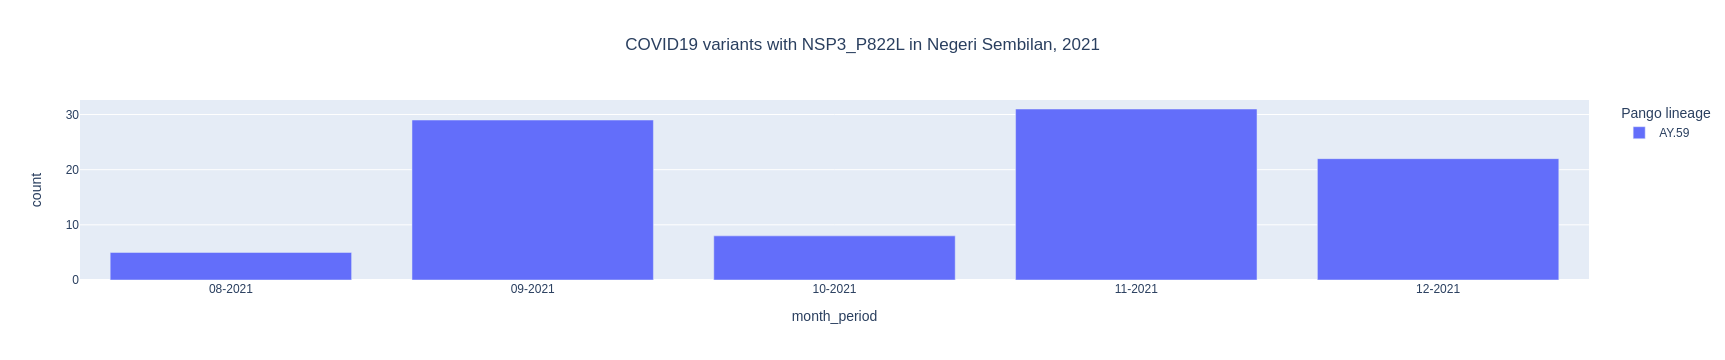

In [18]:
cond1 = malaysia_df["Pango lineage"].isin(["AY.59", "AU.2", "B.1.466.2"])
cond2 = malaysia_df["Location"] == 'Asia / Malaysia / Negeri Sembilan'


fig = get_dist_across_months(malaysia_df.loc[cond1 & cond2, :])
fig.update_layout(title_text=f"COVID19 variants with {mut} in Negeri Sembilan, 2021", title_x=0.5)
fig.show()

Just one lineage only. Quite impressive too, B.1.466.2 and and AU.2 weren't around in Negeri Sembilan (unless if sequencing was lacking in the early part of the year around Negeri Sembilan).

And although AY.59 started appearing in Malaysia in around May, it only appeared on August, when it's prevalence in Malaysia peaked.

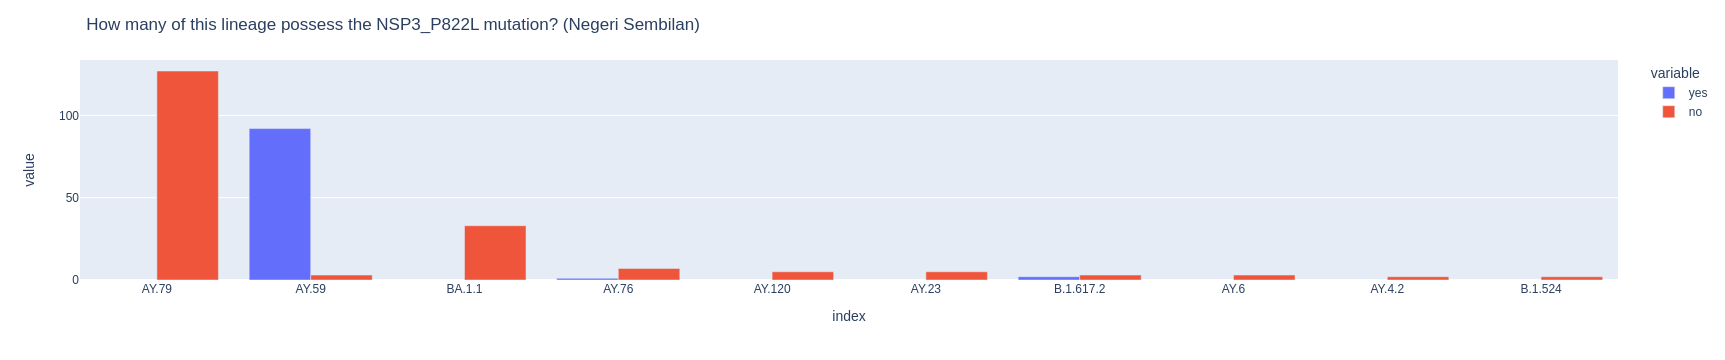

In [19]:
fig = plot_compare_mut(n9_df, mut)
fig.update_layout(title_text=f"How many of this lineage possess the {mut} mutation? (Negeri Sembilan)")
fig.show()

In [20]:
start_date = "2021-01-01"
end_date = "2021-12-31"

dates_column = ["Collection date", "Submission date"]

malaysia_df = pd.read_csv("metadata_Malaysia.tsv", sep = "\t")

for d in dates_column:
    malaysia_df[d] = pd.to_datetime(malaysia_df[d])

mask = (malaysia_df['Collection date'] > start_date) & (malaysia_df['Collection date'] <= end_date)

malaysia_df = malaysia_df.loc[mask, :]

for d in dates_column:
    malaysia_df[d] = malaysia_df[d].dt.strftime("%Y-%m-%d")

In [21]:
gisaid_ids = ["EPI_ISL_8745621", "EPI_ISL_8745619", "EPI_ISL_8745617", "EPI_ISL_8745616", "EPI_ISL_8745615", "EPI_ISL_8745614", "EPI_ISL_8438480", "EPI_ISL_8408361", "EPI_ISL_8408360", "EPI_ISL_8314874", "EPI_ISL_7831404", "EPI_ISL_7831402", "EPI_ISL_7831401", "EPI_ISL_7831394", "EPI_ISL_7831392", "EPI_ISL_7831390", "EPI_ISL_7831387", "EPI_ISL_7831385", "EPI_ISL_7464488", "EPI_ISL_7464487", "EPI_ISL_7464478", "EPI_ISL_7464475", "EPI_ISL_7464472", "EPI_ISL_7464471", "EPI_ISL_7464468", "EPI_ISL_7260006", "EPI_ISL_6825272", "EPI_ISL_6825271", "EPI_ISL_6825270", "EPI_ISL_6825266", "EPI_ISL_6825265", "EPI_ISL_6825264", "EPI_ISL_6825263", "EPI_ISL_6705577", "EPI_ISL_6705529", "EPI_ISL_6705517", "EPI_ISL_6705491", "EPI_ISL_6567075", "EPI_ISL_6567074", "EPI_ISL_6567073", "EPI_ISL_6567072", "EPI_ISL_6567071", "EPI_ISL_6567068", "EPI_ISL_6567066", "EPI_ISL_6567064", "EPI_ISL_6452645", "EPI_ISL_6452630", "EPI_ISL_6452618", "EPI_ISL_6452588", "EPI_ISL_6452563", "EPI_ISL_6452557", "EPI_ISL_5881287", "EPI_ISL_5742697", "EPI_ISL_5742693", "EPI_ISL_5742682", "EPI_ISL_5742681", "EPI_ISL_5742675", "EPI_ISL_5742665", "EPI_ISL_5742659", "EPI_ISL_5428878", "EPI_ISL_5428873", "EPI_ISL_5428862", "EPI_ISL_5428860", "EPI_ISL_5428562", "EPI_ISL_5428561", "EPI_ISL_5428560", "EPI_ISL_5417637", "EPI_ISL_5417636", "EPI_ISL_5417593", "EPI_ISL_5022688", "EPI_ISL_5022682", "EPI_ISL_5022675", "EPI_ISL_5022673", "EPI_ISL_5022670", "EPI_ISL_4891946", "EPI_ISL_4891942", "EPI_ISL_4891941", "EPI_ISL_4891940", "EPI_ISL_4891939", "EPI_ISL_4891938", "EPI_ISL_4891935", "EPI_ISL_4891929", "EPI_ISL_4816833", "EPI_ISL_4816832", "EPI_ISL_4513510", "EPI_ISL_4463195", "EPI_ISL_4463194", "EPI_ISL_4463193", "EPI_ISL_4071984", "EPI_ISL_4071983", "EPI_ISL_4071981", "EPI_ISL_4071980", "EPI_ISL_4071979", "EPI_ISL_4071978", "EPI_ISL_4071977", "EPI_ISL_3945548", "EPI_ISL_3945547", "EPI_ISL_3945546", "EPI_ISL_3945545"]

In [22]:
sub_malaysia_df = malaysia_df.loc[malaysia_df["Accession ID"].isin(gisaid_ids), :]

In [23]:
sort_columns = [
    "Virus name",
    "Accession ID",
    "Collection date",
    "Location",
    "Additional location information",
    "Sequence length",
    "Patient age",
    "Gender",
    "Clade",
    "Pango lineage",
    "Variant",
    "AA Substitutions",
    "Submission date"
]
# sub_malaysia_df.loc[:, sort_columns].to_excel("subset_99.xlsx", index = False)

### Looking at specific subset of **99 samples**

In [24]:
# get list of mutations

a = [i[1:-1].split(",") for i in sub_malaysia_df["AA Substitutions"].tolist()]
b = [j for i in a for j in i]
c = pd.DataFrame.from_dict(Counter(b), orient = "index").reset_index()
c.columns = ["mutations", "count"]

In [25]:
# genes
all_genes = sorted(list(set([re.sub("_.*", "", i) for i in c["mutations"]])))

In [27]:
orf1a = [f"NSP{i}" for i in range(1, 12) if f"NSP{i}" in all_genes]
# NSP7 and NSP11 missing

orf1b = [f"NSP{i}" for i in range(12, 17) if f"NSP{i}" in all_genes]

No mutations detected in NSP7 and NSP11 of orf1a.

In [28]:
def gen_mut_table(gene_list):
    d = {}
    for i in gene_list:
        for m in c["mutations"]:
            if f"{i}_" in m:
                ans = get_mutation(sub_malaysia_df, m)
                d[m] = ans

    d = pd.DataFrame(d)

    l = list(d.keys())
    c1 = [int(re.sub("NSP", "", re.sub("_.*", "", i))) for i in list(l)]
    c2 = [int(re.sub("[A-Za-z]", "", re.sub(".*_", "", i))) for i in list(l)]
    sorting_key = lambda x: (c1[l.index(x)], c2[l.index(x)])

    l = sorted(l, key = sorting_key)

    d = d.loc[:, l]
    d.index = sub_malaysia_df["Accession ID"]
    
    return d

In [29]:
df_orf1a = gen_mut_table(orf1a)
df_orf1b = gen_mut_table(orf1b)

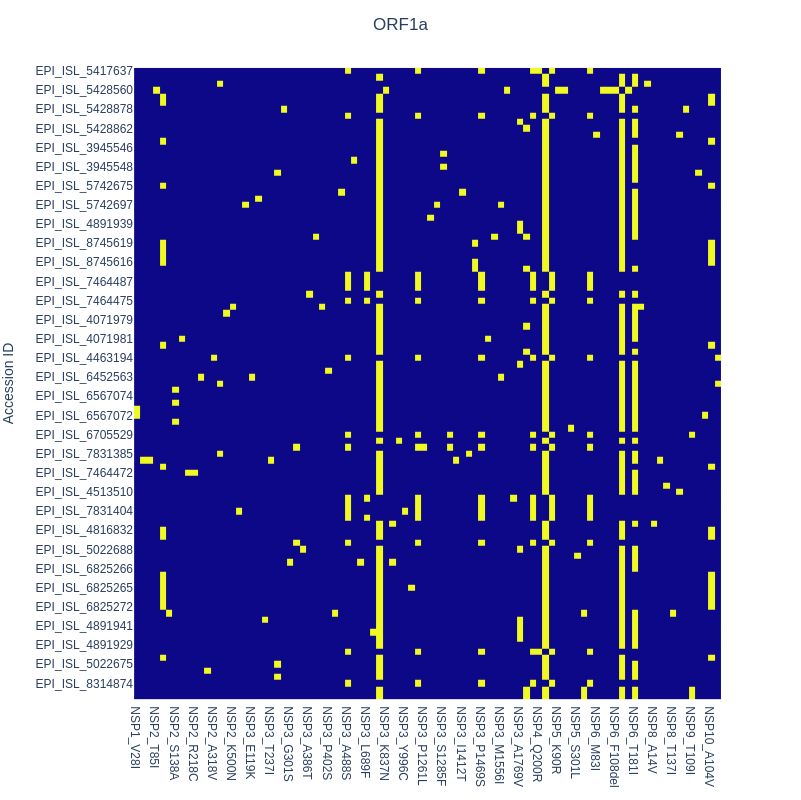

In [35]:
fig = px.imshow(df_orf1a)
fig.update_layout(
    height=800
)
fig.update_layout(title_text=f'ORF1a', title_x=0.5)
fig.update(layout_coloraxis_showscale=False)
# ax.set_xticklabels(d.columns)
# ax.set_yticklabels(d.index)

# d.sum(axis = "columns").to_clipboard()

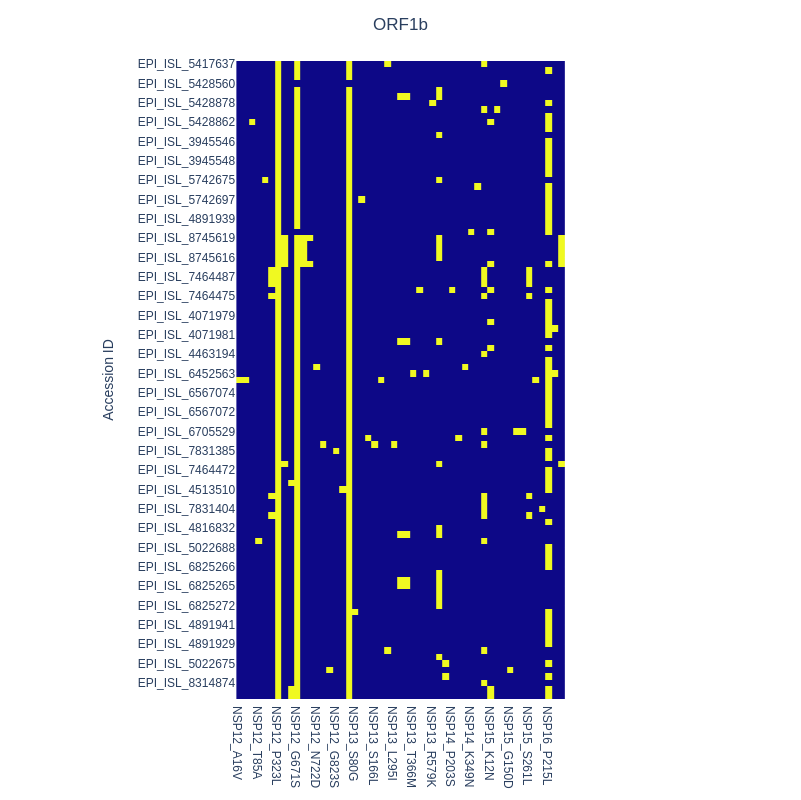

In [36]:
fig = px.imshow(df_orf1b)
fig.update_layout(
    height=800
)
fig.update_layout(title_text=f'ORF1b', title_x=0.5)
fig.update(layout_coloraxis_showscale=False)

### Top 5 mutations in orf1a

In [ ]:
def summarise_mut_table(mut_table):
    e = pd.DataFrame(index = mut_table.columns)
    e["Gene"] = mut_table.sum().index.str.replace("_.*", "", regex = True)
    e["AA substitution"] = e.index.str.replace(".*_", "", regex = True)
    e["No. of occurrence"] = mut_table.sum().astype(str) + f"/{mut_table.shape[0]}" 
    e["Frequencies"] = mut_table.sum()/mut_table.shape[0]*100
    e.sort_values("Frequencies", ascending = False, inplace = True)
    
    return e

summarise_mut_table(df_orf1a).head()

Count
NSP6_V149A   82/99
NSP4_A446V   82/99
NSP3_P822L   81/99
NSP6_T181I   63/99
NSP10_A104V  19/99

### Top 5 mutations in orf1b

In [44]:
summarise_mut_table(df_orf1b).head()

Count
NSP12_P323L  99/99
NSP13_P77L   98/99
NSP12_G671S  97/99
NSP16_P215L  61/99
NSP14_P46L   19/99

## Tickling my fancy:
### AY.23 is very little in Negeri Sembilan?! But almost 25% of Malaysians in 2021 who got COVID19 were infected by this lineage?

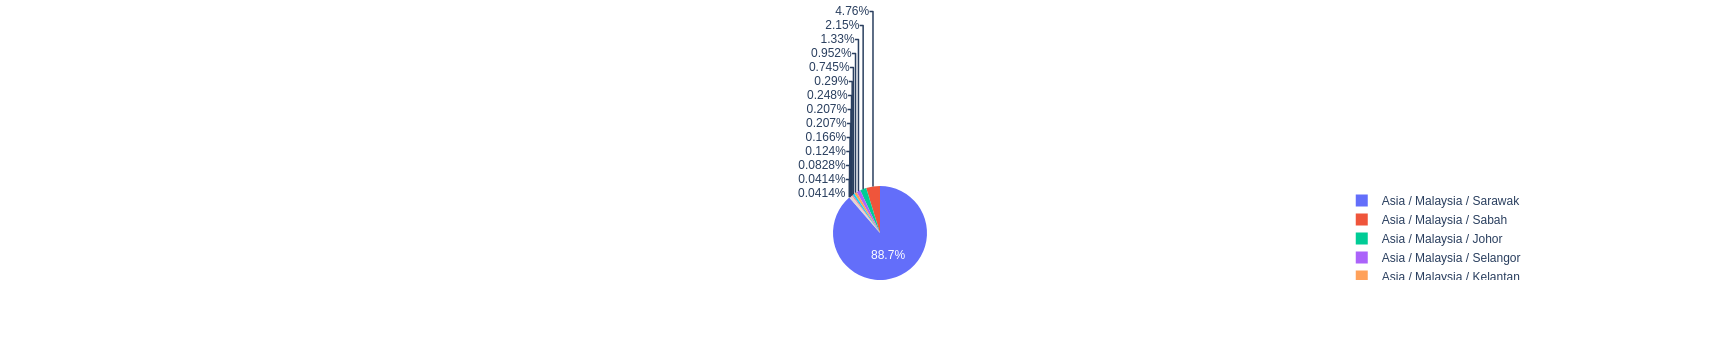

In [34]:
def get_location_pie(df, variant):
    sdf = df.loc[df["Pango lineage"] == variant, :]["Location"].value_counts()
    sdf = pd.DataFrame(sdf)
    sdf.columns = ["count"]
    # return sdf
    fig = px.pie(sdf, values = 'count', names = sdf.index)
    return fig

fig = get_location_pie(malaysia_df, "AY.23")
fig.show()

Patut la. Over 93% from Sabah and Sarawak.